# Memory experiment: Compute $ \langle \bar{0} | \bar{X} | \bar{0} \rangle$ with the seven-qubit Steane code

In [106]:
from typing import List, Dict, Sequence
import itertools
import functools
import numpy as np
import matplotlib._docstring as docstring
import cirq
import qiskit
import qiskit_ibm_runtime
from qiskit_aer import AerSimulator

import matplotlib.pyplot as plt

from mitiq import PauliString

from encoded.diagonalize import get_stabilizer_matrix_from_paulis, get_measurement_circuit, get_paulis_from_stabilizer_matrix

## Set parameters

In [107]:
n = 7                                   # Number of physical qubits
nshots = 100_000                        # Number of samples/shots
depths = np.arange(0, 240 + 1, 20)      # Number of X (NOT) gates to perform (each depth should be even to implement a noisy identity)
k = 1                                   # Number of logical qubits.
samples = 100                           # Number of runs to measure variance of expectations over

In [108]:
# Computer and qubits to use.
# Option 1: Use saved noise characteristics.
computer = qiskit_ibm_runtime.fake_provider.FakeKyiv()
# computer = AerSimulator()  # Noiseless simulator - use this for a sanity check to see all computed expectation values (physical and encoded) are 1.0.

# Option 2: Use noise characteristics from most recent calibration.
# service = qiskit_ibm_runtime.QiskitRuntimeService()  # This assumes a saved account.
# computer = service.backend("ibm_kyiv")
# computer = AerSimulator.from_backend(computer)

# See calibration data at https://quantum.ibm.com/services/resources to select good qubits.
layout = {
    1 : [3],
    7 : [3, 4, 5, 15, 21, 22, 23],
}

## Helper functions

In [109]:
# Expectation of pauli on bitstring measured in diagonal basis.
def compute_expectation(
    pauli: cirq.PauliString,
    counts: Dict[str, int],
) -> float:
    if pauli is cirq.PauliString():
        return 1.0

    expectation = 0.0

    indices = [q.x for q in pauli.qubits]
    for key, value in counts.items():
        key = list(map(int, list(key[::-1])))
        expectation += (-1) ** sum([key[i] for i in indices]) * value

    return expectation / sum(counts.values())

# Prepares logical |0> state on Steane Code
def encode_steane(qreg: Sequence[cirq.Qid]) -> cirq.Circuit:
    circuit = cirq.Circuit()

    circuit.append(cirq.H.on(qreg[0]))
    circuit.append(cirq.H.on(qreg[4]))
    circuit.append(cirq.H.on(qreg[6]))

    circuit.append(cirq.CNOT.on(qreg[0], qreg[1]))
    circuit.append(cirq.CNOT.on(qreg[4], qreg[5]))

    circuit.append(cirq.CNOT.on(qreg[6], qreg[3]))
    circuit.append(cirq.CNOT.on(qreg[6], qreg[5]))
    circuit.append(cirq.CNOT.on(qreg[4], qreg[2]))
    
    circuit.append(cirq.CNOT.on(qreg[0], qreg[3]))
    circuit.append(cirq.CNOT.on(qreg[4], qreg[1]))
    circuit.append(cirq.CNOT.on(qreg[3], qreg[2]))

    return circuit

def noisy_identity(qreg, depth) -> cirq.Circuit:
    circuit = cirq.Circuit()
    if depth == 0:
        circuit.append(cirq.I.on_each(qreg))
    for _ in range(depth):
        circuit.append(cirq.X.on_each(qreg))
    return circuit

def strs_to_paulis(pauli_strs : List[str]) -> List[cirq.PauliString]:
    stab_list = []
    for stab_str in pauli_strs:
        stab_list.append(PauliString(stab_str)._pauli)
    return stab_list

def generate_stabilizer_elements(generators: List[cirq.PauliString]) -> List[cirq.PauliString]:
    elements = []
    for string in itertools.chain.from_iterable(itertools.combinations(generators, r) for r in range(len(generators) + 1)):
        elements.append(
            functools.reduce(lambda a, b: a * b, string, cirq.PauliString())
        )
    return elements

# For qiskit circuits
def get_active_qubits(circ):
    dag = qiskit.converters.circuit_to_dag(circ)
    active_qubits = [qubit for qubit in circ.qubits if qubit not in dag.idle_wires()]
    return active_qubits

def get_lst_ev(d_counts, n_counts, observables, stabilizers):
    numerator = 0
    for obs in observables:
        numerator += compute_expectation(obs, n_counts) / len(observables)
    denominator = 0
    for stab in stabilizers:
        denominator += compute_expectation(stab, d_counts) / len(stabilizers)
    return float(np.real_if_close(numerator / denominator))

### Run unmitigated experiment

In [110]:
qreg = cirq.LineQubit.range(k)

unmit_ev_data = []

for i in range(samples):
    unmit_evs = []
    for depth in depths:
        circuit = noisy_identity(qreg, depth)

        circuit.append(cirq.H.on(qreg[0])) # Rotate to measure Pauli X

        circuit = qiskit.QuantumCircuit.from_qasm_str(circuit.to_qasm())
        circuit.measure_active()
        # Compile to device.
        compiled_raw = qiskit.transpile(
            circuit, 
            backend=computer,
            initial_layout=layout[1],  # Hardcode n = 1 (i.e., no encoding) to get layout.
            routing_method="sabre",
            # scheduling_method="asap",
            optimization_level=0,
        )

        job = computer.run(compiled_raw, shots=nshots)
        counts = job.result().get_counts()
        ev = compute_expectation(PauliString("X")._pauli, counts)

        unmit_evs.append(ev)
        # print(ev)

    unmit_ev_data.append(unmit_evs)
    print(i)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


# Run encoded experiment

In [111]:
generator_strs = [
    "XXXXIII",
    "IXXIXXI",
    "IIXXIXX",
    "ZZZZIII",
    "IZZIZZI",
    "IIZZIZZ"
]

observable = PauliString("X" * n)._pauli

qreg = cirq.LineQubit.range(n)

stabilizer_generators = strs_to_paulis(generator_strs)
stabilizer_matrix = get_stabilizer_matrix_from_paulis(stabilizer_generators, qreg)
measurement_circuit_denominator, transformed_matrix = get_measurement_circuit(stabilizer_matrix)
measurement_circuit_numerator = measurement_circuit_denominator.copy()
measurement_circuit_numerator.insert(0, cirq.H.on_each(qreg))

transformed_generators = get_paulis_from_stabilizer_matrix(transformed_matrix)
stabilizer_elements = generate_stabilizer_elements(transformed_generators)
# for stab in stabilizer_elements:
#     print(stab)

transformed_observable = observable.conjugated_by(measurement_circuit_numerator**-1)
observable_elements = [transformed_observable * stab for stab in stabilizer_elements]
# for obs in observable_elements:
#     print(obs)
# print(measurement_circuit)


In [112]:
from qiskit.circuit.library import Barrier
encoding = encode_steane(qreg)
encoding = qiskit.QuantumCircuit.from_qasm_str(encoding.to_qasm())

# Convert to qiskit circuit
measurement_denominator = qiskit.QuantumCircuit.from_qasm_str(measurement_circuit_denominator.to_qasm())
measurement_numerator = qiskit.QuantumCircuit.from_qasm_str(measurement_circuit_numerator.to_qasm())

# Combine circuit segments
circ_denominator_full = encoding.compose(
        Barrier(n, label="encoding"), get_active_qubits(encoding)
    ).compose(Barrier(n, label="measurement"), get_active_qubits(encoding)
).compose(measurement_denominator)
circ_denominator_full.measure_active()

circ_numerator_full = encoding.compose(
        Barrier(n, label="encoding"), get_active_qubits(encoding)
    ).compose(Barrier(n, label="measurement"), get_active_qubits(encoding)
).compose(measurement_numerator)
circ_numerator_full.measure_active()

# Compile circuits
denominator_noiseless_compiled = qiskit.transpile(
    circ_denominator_full, 
    backend=computer,
    initial_layout=layout[n],
    routing_method="sabre",
    # scheduling_method="asap",
    optimization_level=3,
)

numerator_noiseless_compiled = qiskit.transpile(
    circ_numerator_full, 
    backend=computer,
    initial_layout=layout[n],
    routing_method="sabre",
    # scheduling_method="asap",
    optimization_level=3,
)

print(denominator_noiseless_compiled.draw(fold=-1, idle_wires=False))
print(numerator_noiseless_compiled.draw(fold=-1, idle_wires=False))
# encoding_compiled.count_ops()

global phase: π/2
           ┌─────────┐ ┌────┐ ┌─────────────┐ ┌────┐┌─────────┐┌──────┐   ┌─────────┐   ┌────┐┌─────────────┐┌────┐┌──────────┐                                                                                                                                                                                                                                                                                    ┌──────┐┌──────────┐ ┌────┐ ┌──────────────┐                                                                                                                                                                                                                         encoding  measurement ┌─────────┐┌────┐┌────────┐┌──────┐┌─────────┐ ┌────┐          ┌──────┐┌──────────┐                 ┌──────┐ ┌────────┐  ┌────┐  ┌────────┐                                    ┌──────┐  ┌──────────┐    ┌────┐    ┌─────────┐  ┌──────┐   ┌────┐  ┌──────────────┐  ┌────┐  ┌──────────┐               

### Add (noisy) identity to circuit and compute expectation values

In [113]:
mit_ev_data = []

for i in range(samples):
    mit_evs = []
    for depth in depths:
        denominator_compiled = denominator_noiseless_compiled.copy_empty_like()
        for instruction in denominator_noiseless_compiled.data:
            if instruction.label == "measurement":
                for _ in range(depth):
                    for q in get_active_qubits(denominator_compiled):
                        denominator_compiled.x(q)
            denominator_compiled.append(
                instruction, instruction.qubits
            )

        numerator_compiled = numerator_noiseless_compiled.copy_empty_like()
        for instruction in numerator_noiseless_compiled.data:
            if instruction.label == "measurement":
                for _ in range(depth):
                    for q in get_active_qubits(numerator_compiled):
                        numerator_compiled.x(q)
            numerator_compiled.append(
                instruction, instruction.qubits
            )
            
        job = computer.run(
            [denominator_compiled, numerator_compiled],
            shots=nshots,
        )
        d_counts = job.result().get_counts()[0]
        n_counts = job.result().get_counts()[1]
        ev = get_lst_ev(d_counts, n_counts, observable_elements, stabilizer_elements)
        mit_evs.append(ev)
        # print(ev)
    mit_ev_data.append(mit_evs)
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


### Make the measurement/diagonalization circuit noiseless and compute expectation values

In [114]:
from qiskit.circuit.library import UnitaryGate
from qiskit.transpiler import InstructionProperties

ideal_props = {
    (i,) : InstructionProperties(error=0.0, duration=0.0) for i in range(computer.num_qubits)
}

computer.target.add_instruction(UnitaryGate([[1, 0], [0, 1]]), ideal_props)
print(computer.target._gate_map['unitary'])

{(0,): InstructionProperties(duration=0.0, error=0.0, calibration=None), (1,): InstructionProperties(duration=0.0, error=0.0, calibration=None), (2,): InstructionProperties(duration=0.0, error=0.0, calibration=None), (3,): InstructionProperties(duration=0.0, error=0.0, calibration=None), (4,): InstructionProperties(duration=0.0, error=0.0, calibration=None), (5,): InstructionProperties(duration=0.0, error=0.0, calibration=None), (6,): InstructionProperties(duration=0.0, error=0.0, calibration=None), (7,): InstructionProperties(duration=0.0, error=0.0, calibration=None), (8,): InstructionProperties(duration=0.0, error=0.0, calibration=None), (9,): InstructionProperties(duration=0.0, error=0.0, calibration=None), (10,): InstructionProperties(duration=0.0, error=0.0, calibration=None), (11,): InstructionProperties(duration=0.0, error=0.0, calibration=None), (12,): InstructionProperties(duration=0.0, error=0.0, calibration=None), (13,): InstructionProperties(duration=0.0, error=0.0, calibr

In [115]:
from qiskit.circuit.library import UnitaryGate
denominator_noiseless_compiled_perfect_measurment = denominator_noiseless_compiled.copy_empty_like()

enc = True
mea = False
for instruction in denominator_noiseless_compiled.data:
    # print(instruction)
    if not mea and instruction.label != "encoding" and instruction.label != "measurement":
        op = instruction
    elif instruction.label == "encoding":
        enc = False
        op = instruction
    elif instruction.label == "measurement":
        mea = True
        op = instruction
    elif instruction.matrix is None:
        op = instruction
    else:
        op = UnitaryGate(instruction.matrix, label="ideal_" + instruction.operation.name)
    denominator_noiseless_compiled_perfect_measurment.append(
        op, instruction.qubits
    )

numerator_noiseless_compiled_perfect_measurment = denominator_noiseless_compiled.copy_empty_like()

enc = True
mea = False
for instruction in numerator_noiseless_compiled.data:
    # print(instruction)
    if not mea and instruction.label != "encoding" and instruction.label != "measurement":
        op = instruction
    elif instruction.label == "encoding":
        enc = False
        op = instruction
    elif instruction.label == "measurement":
        mea = True
        op = instruction
    elif instruction.matrix is None:
        op = instruction
    else:
        op = UnitaryGate(instruction.matrix, label="ideal_" + instruction.operation.name)
    numerator_noiseless_compiled_perfect_measurment.append(
        op, instruction.qubits
    )
# print(noiseless_compiled_perfect_measurment.count_ops())
print(denominator_noiseless_compiled_perfect_measurment.draw(fold=-1, idle_wires=False))
print(numerator_noiseless_compiled_perfect_measurment.draw(fold=-1, idle_wires=False))

global phase: π/2
           ┌─────────┐ ┌────┐ ┌─────────────┐ ┌────┐┌─────────┐┌──────┐   ┌─────────┐   ┌────┐┌─────────────┐┌────┐┌──────────┐                                                                                                                                                                                                                                                                                    ┌──────┐┌──────────┐ ┌────┐ ┌──────────────┐                                                                                                                                                                                                                         encoding  measurement ┌──────────┐┌──────────┐┌──────────┐┌────────────┐┌──────────┐┌──────────┐            ┌────────────┐┌──────────┐                        ┌────────────┐┌──────────┐ ┌──────────┐ ┌──────────┐                                        ┌────────────┐┌──────────┐┌──────────┐ ┌──────────┐ ┌────────────┐┌─

In [116]:
mit_ev_im_data = []

for i in range(samples):
    mit_evs_im = []
    for depth in depths:
        denominator_compiled = denominator_noiseless_compiled_perfect_measurment.copy_empty_like()
        for instruction in denominator_noiseless_compiled_perfect_measurment.data:
            if instruction.label == "measurement":
                for _ in range(depth):
                    for q in get_active_qubits(denominator_compiled):
                        denominator_compiled.x(q)
            denominator_compiled.append(
                instruction, instruction.qubits
            )

        numerator_compiled = numerator_noiseless_compiled_perfect_measurment.copy_empty_like()
        for instruction in numerator_noiseless_compiled_perfect_measurment.data:
            if instruction.label == "measurement":
                for _ in range(depth):
                    for q in get_active_qubits(numerator_compiled):
                        numerator_compiled.x(q)
            numerator_compiled.append(
                instruction, instruction.qubits
            )

        job = computer.run(
            [denominator_compiled, numerator_compiled],
            shots=nshots,
        )
        d_counts = job.result().get_counts()[0]
        n_counts = job.result().get_counts()[1]
        ev = get_lst_ev(d_counts, n_counts, observable_elements, stabilizer_elements)

        mit_evs_im.append(ev)
        # print(ev)

    mit_ev_im_data.append(mit_evs_im)
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


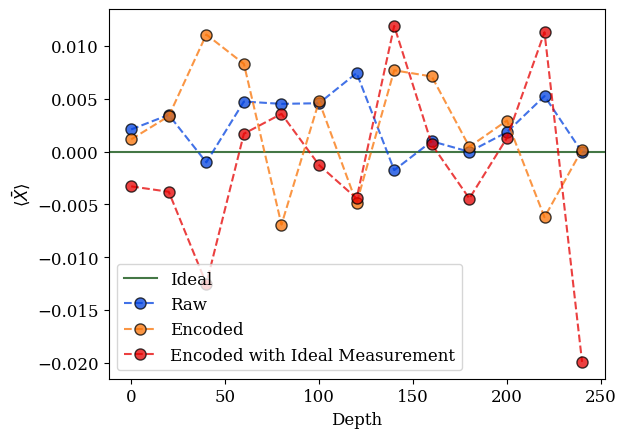

In [42]:
plt.rcParams.update({"font.family": "serif", "font.size": 12})
colors = ["xkcd:blue", "xkcd:orange", "xkcd:red"]
alpha: float = 0.75
stop: int = 15

# plt.title("Measuring $\\langle\\overline{Z}\\rangle$ on $|0\\rangle$ with Steane [[7,1,3]] Code")
plt.ylabel(r"$\langle \bar{X} \rangle$")
plt.xlabel("Depth")
# plt.plot(depths[:stop], [1.0] * len(depths[:stop]), "--", label="Ideal")
plt.axhline(0.0, label="Ideal", alpha=0.75, color="xkcd:darkgreen")
plt.plot(depths[:stop], unmit_evs[:stop], "--o", color=colors[0], alpha=alpha, mec="black", ms=8, label="Raw")
plt.plot(depths[:stop], mit_evs[:stop], "--o", alpha=alpha, color=colors[1], mec="black", ms=8, label="Encoded")
plt.plot(depths[:stop], mit_evs_im[:stop], "--o", alpha=alpha, color=colors[2], mec="black", ms=8, label="Encoded with Ideal Measurement")
plt.legend();
# plt.savefig(f"color_memory_steane_[[7,1,3]]_logical_zero_logical_z_{computer.name}.pdf")

In [102]:
unmit_ev_data = [
    [0.00074, 0.0068, 0.00884, 0.00746, 0.00616, 0.0033, 0.0043, -0.00478, 0.00056, 0.0055, 0.00356, 0.00592, 0.00872],
    [0.0089, 0.01332, 0.01018, 0.00376, 0.00126, 0.00174, 0.00218, 0.00194, 0.00152, 0.0022, 0.00742, 0.00272, 0.00146],
    [0.00784, 0.00596, 0.00618, 0.006, 0.0023, 0.00638, 0.0015, 0.00762, 0.0051, 0.00362, 0.00854, 0.00532, 0.00544],
    [0.00334, 0.00348, 0.0003, 0.00108, 0.00428, -0.00022, -0.00312, 0.005, 0.0032, 0.00102, 0.00546, -0.00082, 0.00602],
    [0.00376, -0.00332, 0.00456, 0.00114, 0.00112, 0.00966, 0.00382, -0.00206, 0.0044, 0.00408, 0.00234, -0.00116, 0.00824],
    [0.00324, 0.00654, 0.00162, 0.0074, 0.00328, 0.00548, 0.00402, 0.01428, 0.00962, 0.00584, 0.00636, 0.00084, 0.0003],
    [0.00374, 0.00126, 0.00124, 0.0081, 0.00308, 0.00324, 0.00472, -0.00158, 0.00674, 0.00058, -0.002, 0.00236, 0.0043],
    [0.00078, 0.0019, 0.01148, 0.00602, 0.00656, 0.00586, -0.0012, 0.00154, 0.0035, -0.0043, 0.00628, 0.00296, 0.0073],
    [0.00488, -0.00252, 0.0009, 0.00386, -0.00362, 0.00188, 0.00264, 0.00976, 0.00734, 8e-05, 0.00288, 0.00354, -0.00222],
    [0.00794, 0.00704, 0.00888, 0.00074, -0.00334, 0.00234, 0.00444, 0.0093, 0.00134, 0.00818, 0.00994, 0.00378, 0.00482]
]
mit_ev_data = [
    [0.0011591088996946734, 0.003349709691826709, 0.011086258873869496, 0.008305747818236535, -0.0069201577498325785, 0.004769475357710652, -0.004883745620554198, 0.007696933253156945, 0.007113139175949534, 0.00044883303411131137, 0.0029387755102040828, -0.006217616580310879, 0.0001904399162064388],
    [-0.003494715308557789, -0.0014877078141852943, -0.005266937993775432, -0.0045849125810001265, 0.006391938637389087, -0.003829029385574356, 0.0018836333193804947, 0.0026359932901988963, -0.0065984379208187454, 0.008994396933058101, 0.01235788433020268, 0.0003567606136282568, 0.0011569610489780171],
    [0.003934314060896339, 0.011118598382749324, 0.020037752286917385, 0.010741594853744388, -0.003919499510062559, -0.0074794989636838794, -0.023781963590445127, 0.02028881728129849, 0.010060362173038231, 0.017014925373134326, -0.018908253863860563, -0.0017630465444287723, -0.030421799178798052],
    [0.006105006105006105, 0.008851549021078682, -0.0013001396446284974, -0.0037883416839789795, 0.008184030081840299, 0.006061686575147083, 0.0062195501192080435, -0.01796407185628743, 0.0018676627534685171, -0.014514439622923831, 0.004170676932948349, 0.000697836706210749, -0.00566465256797583],
    [0.001853647407745395, -0.0029549279970076674, 0.004223095966215234, 0.01478040540540541, 0.004400357995226731, 0.0053585781905867635, 0.012238124870358845, -0.0021221410044800757, -0.009035738368172622, 0.017593984962406023, 0.007127814676818407, 0.004208311415044714, -0.006141820212171974],
    [0.0023356499943032925, -0.005981902850868891, 0.015687420832115363, -0.005379918998972377, 0.008325134337394988, -0.006215040397762586, -0.0024073686414067407, -0.002388915432393693, 0.016085059978189757, -0.0016474464579901158, -0.010012919896640821, 3.3413528491293905e-19, 0.004726791453961051],
    [-0.006232471174820817, -0.0003768323472886907, 0.00043814809405579106, 0.0074784391773716884, -0.00081887888036924, -0.0038578862372151443, 0.010272906506174124, 0.008473550417624983, -0.00209863588667366, 0.010399643440796316, -0.0044488383588729636, -0.029105662374316447, 0.004541154210028381],
    [0.0005119308324564146, 0.0006358705816345619, -0.003539222340734996, -0.006112095837662736, 0.006780160660328689, -0.010641151748189217, 0.0028762198253723674, 0.0005929088106249254, 0.014721772015126951, 0.024114319738017267, -0.007275666936135814, -0.006330258636281423, 0.023052009906648893],
    [-0.0020463265596134734, -0.002744876856551985, 0.002779809802487198, -0.00534986929296614, -0.001563663440059568, 0.012072974423180107, 0.011419591409114716, 0.006944444444444446, -0.004725897920604916, 0.02875778238956419, -0.02047270306258323, 0.003737319807794979, -0.0041635124905374694],
    [0.01031278331822303, 0.00011269722013523611, 0.006294525226895679, -0.005892100902227951, 0.0008234149262669357, 0.0054508086855508875, 0.013593256059009478, -0.003911806543385489, 0.018150040333422962, 0.00573276495663678, -0.00048677592081778286, 0.03307254623044095, -0.003062787136294027],
    [0.0024767801857585136, 0.0045309366411646745, -0.0021263229111293668, -0.002595521216876924, -0.0029204732664370233, -0.017606260003556824, 0.0038569790472219303, -0.013319062908788207, 0.003075688686814659, -0.03481156349326472, 0.014571948998178506, 0.009786476868327404, -0.008075117370892023]
]
mit_ev_im_data = [
    [-0.005526807311920147, 0.004475007697834342, -0.004678710514928605, -6.914912007744697e-05, 0.00809469927756985, 0.0005290445455507357, -0.003800595426616838, -0.006009793737943316, 0.006185916447758661, 0.018996314148001132, -0.02531914893617019, 0.011054223877123575, -0.001290322580645161],
    [0.0069398697816928385, 0.00582304526748971, -0.0029516098459205493, -0.0047442601378259504, 0.0049290643350049295, -0.003724687860665199, 0.00207887110999118, -0.0004419238417912652, 0.015423092955398086, -0.003741007194244607, 0.008857204579822857, 0.008147615624251139, 0.012022272842318403],
    [0.0005335203195024541, -0.005278819501059841, -0.005414777273939716, 0.01263877028181042, 0.0018110473890733478, -0.011279576097791306, -0.0004395328393821424, -0.006024096385542167, -0.003158613624722553, -0.0055998481397114665, 0.012675905038135132, 0.005902490851139182, -0.007782101167315177],
    [-0.00032080169872137607, -0.0003890572528462613, -0.007820136852394915, -0.0002414792327859808, 0.0061752385887636554, -0.01114827201783724, 0.0012098057943330143, -0.02174392125174466, -0.00758947822337214, -0.010012164311780671, -0.023753728163613125, 0.012329882517157153, -0.00900321543408361],
    [0.0009473169539176144, -0.00016389076680392524, 0.005030803583438703, -0.005796901418170527, 0.011814928204907071, -0.003811944091486659, 0.0041924785682998554, -0.005063668180802737, 0.005656496400411383, 0.009831996945399012, 0.004165331624479332, -0.006019912016670523, 0.0027879863135217326],
    [0.004115604106424318, 0.010081799591002043, -0.006971548545126649, 0.006685966363385718, -0.006849021874063608, -0.005105296745373327, 0.010206685378923195, -0.005026611472501479, -0.015367445054945056, 0.0038613765807510385, 0.012532912058978413, 0.0017783046828689984, 0.0015467904098994594],
    [0.002219229238727846, -0.012017308204991488, 0.0013714470110522494, 0.0001737196859148079, 0.0031424881618596643, -0.00010583130489998956, -0.0050450904963107775, 0.00521100917431193, 0.0024454001180537993, 0.0010637269122908816, 0.002369923516104708, 0.011967003601719536, -0.0005100089251561908],
    [0.004559316864897835, -0.004752540150770239, 0.0029668831689519688, -0.004436587986551592, 0.00021675047685104914, 0.001901040291492846, -0.006286145335680162, -0.002828222685323011, -0.00860196368059779, -0.0063176031396573185, -0.004683840749414516, -0.012878003909394042, 0.002470098803952158],
    [0.010336947686456148, -0.0005130836326321191, -0.003242055624028722, -0.00722957304596917, -0.005453452421848162, 0.003136796214578128, 0.013898584755981467, -0.002968900764491947, 0.0036608207049208226, -0.013142636258214147, -0.010213751711066657, 0.005225267069205758, -0.005885430290347894],
    [0.0005340657663843749, -0.008967413609127471, 0.009010462895720705, 0.0011454356126345021, -0.0028850708349481124, 0.003865238965787415, 0.0012558081125204072, -0.0027965852222549313, -0.00041785057663379604, 0.002703746620316726, -0.017786771754180423, 0.0007094714437743886, -0.0172215843857635]
]

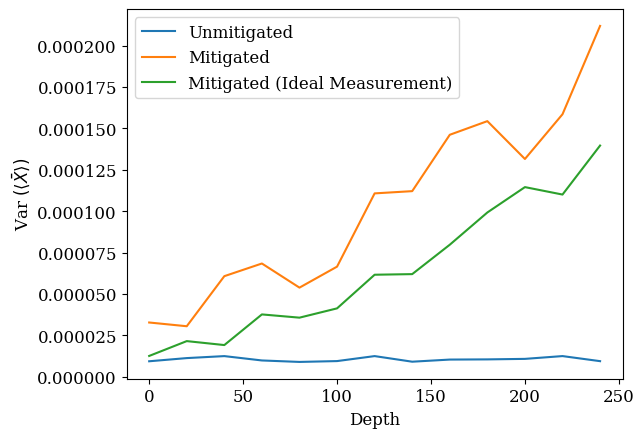

In [117]:
plt.plot(depths, np.var(unmit_ev_data, 0), label="Unmitigated")
plt.plot(depths, np.var(mit_ev_data, 0), label="Mitigated")
plt.plot(depths, np.var(mit_ev_im_data, 0), label="Mitigated (Ideal Measurement)")
plt.xlabel("Depth")
plt.ylabel(r"Var $(\langle \bar{X} \rangle)$")
plt.legend()
